# Lab DL 06 LSTM untuk Forecasting
Nama : Muhammad Fikrizza

NIM  : 2000018096


# **1. Pendahuluan**

**Warning: Sebelum melakukan praktikum ini, diharapkan Anda telah mempelajari teori tentang Long Short Term Memory (LSTM) terlebih dahulu**

Teori tentang LSTM dapat dibaca pada:
https://indoml.com/2018/04/13/pengenalan-long-short-term-memory-lstm-dan-gated-recurrent-unit-gru-rnn-bagian-2/




## Tujuan Praktikum
Tujuan dari praktikum ini adalah untuk mempelajari penggunakan Recurrent Neural Network (RNN) yaitu **Long Short Term Memory (LSTM)** untuk melakukan prediksi pada data yang bersifat *time-series* (data dengan fitur waktu berturutan).

LSTM dapat mengekstraksi interaksi pada data yang bersifat *sequential* (berupa sequence/urutan).

Dataset yang akan digunakan adalah *airline-passangers.csv*

Dataset airline-passangers memiliki dua fitur yaitu bulan dan jumlah penumpang *airline* (*passanger*). 
Jumlah data pada dataset ini adalah 145 data.

Pada praktikum ini akan dibuat sebuah model untuk memprediksi jumlah penumpang *airline* (*passanger*) pada bulan selanjutnya.

Task yang akan dikerjakan tergolong ke dalam kasus Regresi pada data *time-series*.

## Langkah-langkah Praktikum

Langkah-langkah praktikum secara umum :


1.   Load Data yang akan digunakan
2.   Pre-process data (normalisasi)
1.   Split data training dan data test
1.   Ubah data ke dalam bentuk time-series
2.   Training model dengan data training
1.   Test model dengan data test
2.   Lakukan prediksi dengan data baru







Berikut ini adalah tampilan isi dari airline-passangers.csv

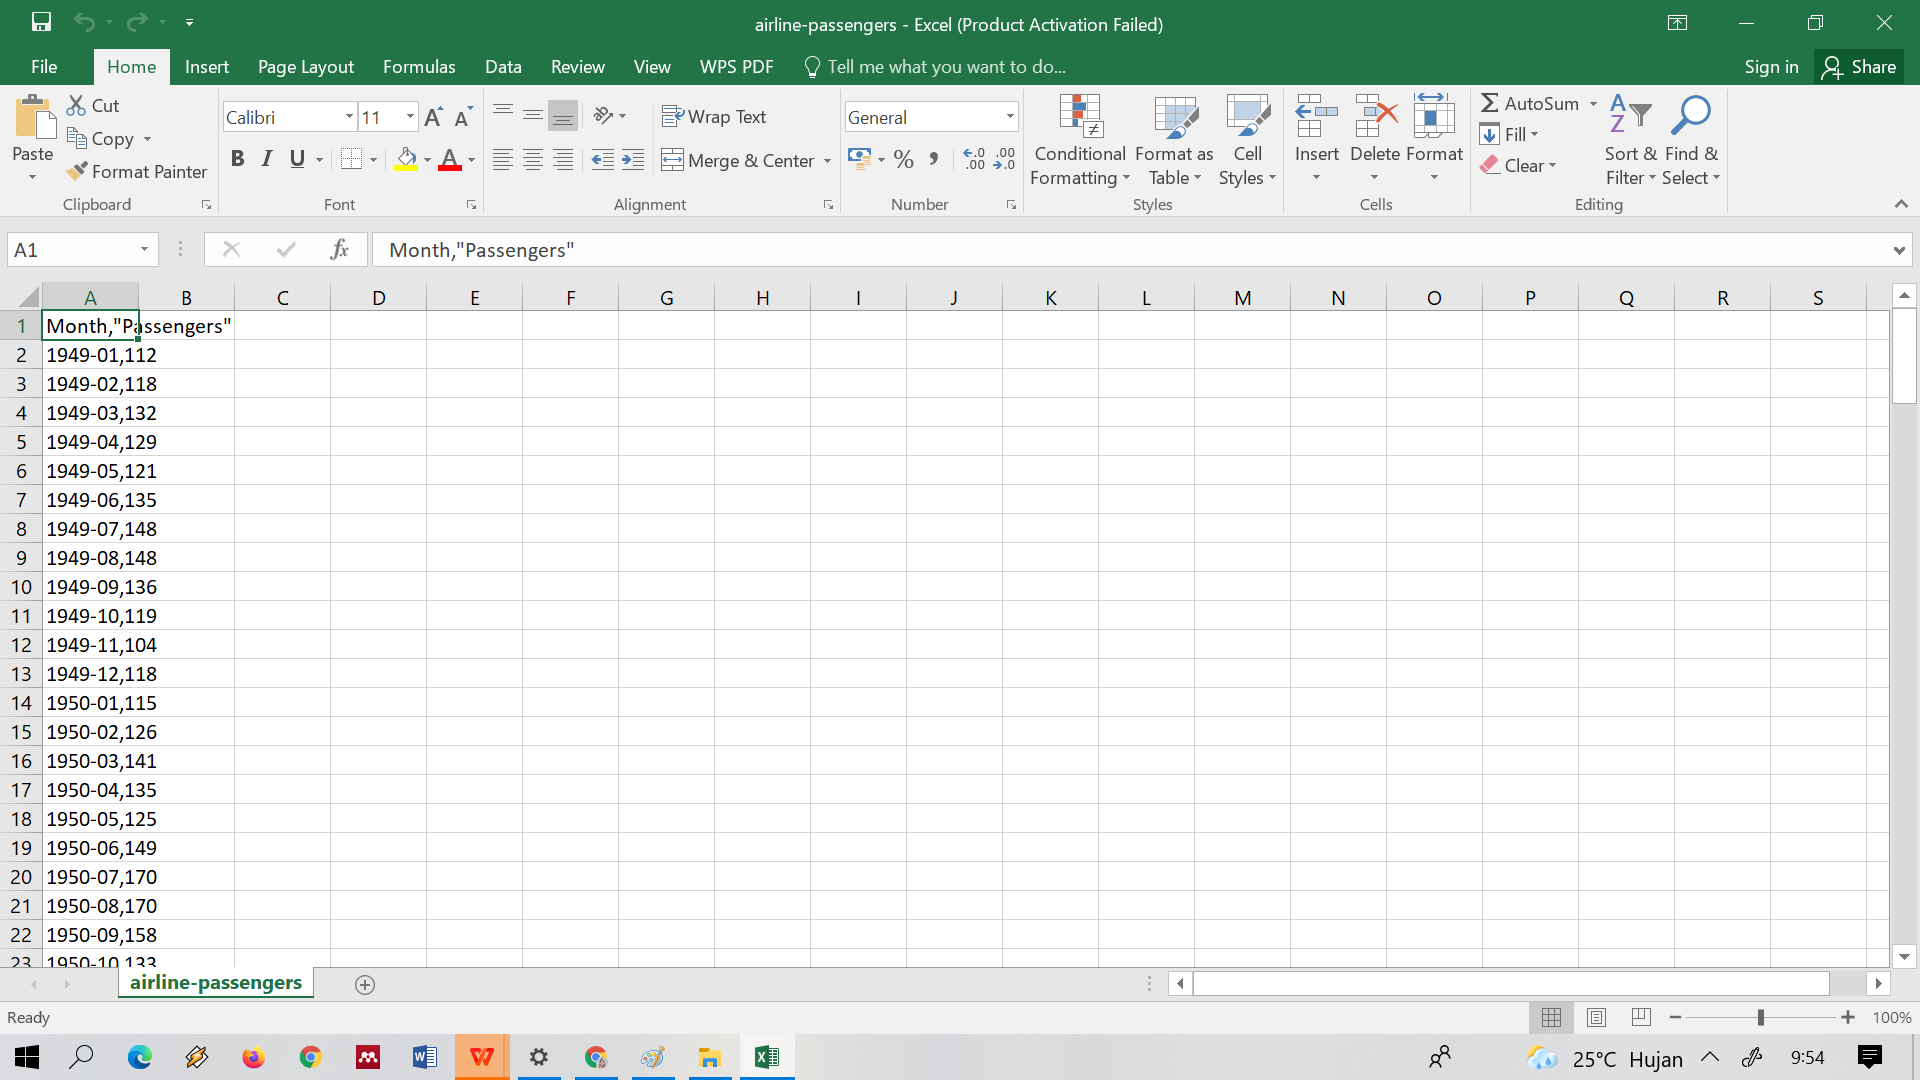

# **2. Mounting Google Drive**

In [4]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/


# **3**. **Import Library yang Akan Digunakan**

In [2]:
# import library yang akan digunakan
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import os

# import library tensorflow untuk implementasi Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# **4. Baca dan Visualisasi Dataset**

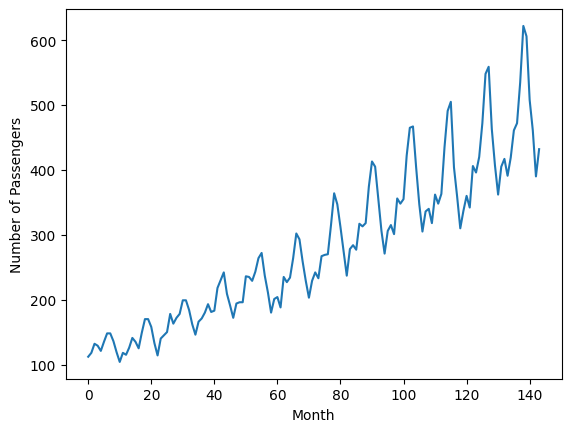

In [5]:
# load data dan lakukan plotting untuk melihat kondisi data
import pandas
import matplotlib.pyplot as plt

datapath = os.path.join(root_path, 'airline-passengers.csv')
dataframe = pandas.read_csv(datapath, usecols=[1], engine='python')
plt.plot(dataframe)
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.show()

Dari gambar plot di atas dapat kita lihat bahwa data penumpang airline (passanger) membentuk sebuah pola. Meskipun data naik turun apabila dilihat dalam scope waktu yang kecil, namun secara keseluruhan data cenderung naik dari bulan ke 1 sampai bulan ke 144.

In [6]:
# data diubah ke dalam format float
dataset_pre_norm = dataframe.values
dataset_pre_norm = dataset_pre_norm.astype('float32')

## **4.1. Normalisasi Data**

LSTM sangat sensitif dengan 'scale' dari data, terutama jika menggunakan fungsi aktivasi default (Sigmoid dan Tanh). Oleh karena itu kita perlu lakukan normalisasi data untuk membuat nilai data berada dalam range 0 sampai 1. Gunakan **MinMaxScaler** untuk melakukan normalisasi data.

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_pre_norm)

## **4.2. Split Data menjadi Data Training dan Data Test**

Selanjutnya yang akan kita lakukan adalah membagi data menjadi training set dan test set. Training set digunakan untuk membangun model, sedangkan test set digunakan untuk menguji performa model yang dibuat.

Dalam kasus ini karena data berjumlah 144, kita gunakan 100 untuk training dan sisanya untuk test.

In [8]:
# split into train and test sets
train_size = 100
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

100 44


Selanjutnya, data yang sudah kita miliki perlu kita ubah bentuknya untuk merepresentasikan data time-series. Dalam hal ini, kita akan menghapus fitur '***month***' pada data *airline-passangers* dan hanya akan menggunakan fitur jumlah passanger saja.

Kemudian, cara membuat data time-series adalah dengan membentuk *sequence* dari data jumlah *passanger* dalam *window* waktu yang tertentu, misalnya 1, 2, 3, atau 4. 

Contoh: Jika kita pilih window = 1, maka setiap data terdiri dari dua nilai yaitu data ke-t dan data ke-t+1. Dalam hal ini nanti data ke-t+1 akan diprediksi dengan hanya menggunakan data ke-t.
Jika kita pilih window = 2, maka setiap data terdiri dari tiga nilai yaitu data ke t-1, data ke-t, dan data ke-t+1. Dalam hal ini nanti data ke-t+1 akan diprediksi dengan data ke t-1 dan data ke-t

Oleh karena itu, kita perlu membuat sebuah fungsi untuk mengkonstruksi (membangun) data time-series dari data *airline-passanger*.

# **5. Pembentukan (Konstruksi) Data Time-Series**

In [9]:
# fungsi untuk meng-convert array ke dalam bentuk matriks time-series 
# dengan window=1, karena dengan window=1 maka variabel look_back = 1, 
# karena data yang akan diambil hanya data ke t dan t+1
# var look_back menyimpan jumlah window yang akan kita gunakan
def create_dataset(dataset, look_back):
    dataX, dataY=[], []
    for i in range(len(dataset) - look_back):
        # perhatikan a akan looping mulai dari data pertama 
        # dan naik ke satu data berikutnya
	    a = dataset[i] 
	    dataX.append(a)
	    dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

Untuk mempermudah pemahaman, berikut ini contoh HASIL jika fungsi create_dataset diaplikasikan pada dataset yang belum dinormalisasi.

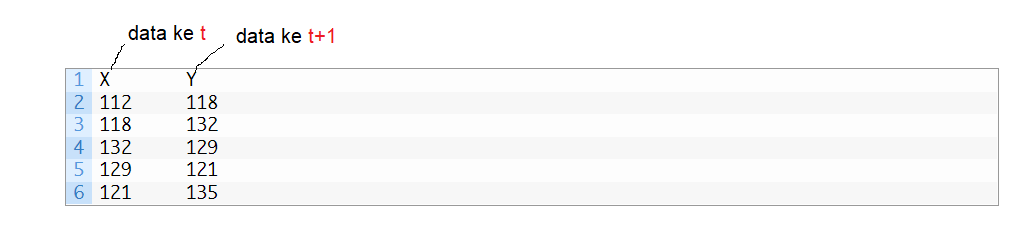

Jadi, fungsi create_dataset menghasilkan dataX yang berisi data ke-t, dan dataY yang berisi data ke-t+1

Mengapa kita perlu membentuk data seperti ini? Karena kita akan menggunakan dataX (data ke t) untuk melakukan prediksi nilai dataY (data ke t+1). 

In [10]:
# panggil fungsi create_dataset pada data yang sudah ternormalisasi
# menghasilkan data X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# tampilkan data pada trainX dan train Y
for i in range (len(trainX)):
    print(trainX[i], trainY[i])

print(len(trainX))
print(len(trainY))

[0.01544401] [0.02702703]
[0.02702703] [0.05405405]
[0.05405405] [0.04826255]
[0.04826255] [0.03281853]
[0.03281853] [0.05984557]
[0.05984557] [0.08494207]
[0.08494207] [0.08494207]
[0.08494207] [0.06177607]
[0.06177607] [0.02895753]
[0.02895753] [0.]
[0.] [0.02702703]
[0.02702703] [0.02123553]
[0.02123553] [0.04247104]
[0.04247104] [0.07142857]
[0.07142857] [0.05984557]
[0.05984557] [0.04054055]
[0.04054055] [0.08687258]
[0.08687258] [0.12741312]
[0.12741312] [0.12741312]
[0.12741312] [0.10424709]
[0.10424709] [0.05598456]
[0.05598456] [0.01930502]
[0.01930502] [0.06949806]
[0.06949806] [0.07915059]
[0.07915059] [0.08880308]
[0.08880308] [0.14285713]
[0.14285713] [0.11389962]
[0.11389962] [0.13127413]
[0.13127413] [0.14285713]
[0.14285713] [0.18339768]
[0.18339768] [0.18339768]
[0.18339768] [0.15444016]
[0.15444016] [0.11196911]
[0.11196911] [0.08108109]
[0.08108109] [0.1196911]
[0.1196911] [0.12934363]
[0.12934363] [0.14671814]
[0.14671814] [0.17181468]
[0.17181468] [0.14864865]
[0.1

Sampai di sini, apakah kalian paham mengapa jumlah data pada trainX dan trainY adalah 99 dan bukan 100? 

# **6. Training Model LSTM**

Selanjutnya, yang akan kita lakukan adalah kita membangun model dengan LSTM untuk memprediksi nilai trainY dengan menggunakan nilai trainX. Setelah model berhasil dibuat, kita akan memprediksi nilai testY dengan menggunakan testX.

LSTM menerima input data dalam struktur array yang spesifik yaitu: **[samples, time steps, features]**.

Saat ini data yang kita miliki berada dalam format **[samples, features]** dan kita berasumsi bahwa satu timestep untuk setiap sample. 

Oleh karena itu, kita perlu melakukan transformasi pada data trainX (yang akan dipakai untuk mentraining model) dan  testX(yang akan dipakai sebagai input saat testing) dengan numpy.reshape().

In [12]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# Cek hasil reshape dengan print
print(trainX)

[[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]

 [[0.05984557]]

 [[0.08494207]]

 [[0.08494207]]

 [[0.06177607]]

 [[0.02895753]]

 [[0.        ]]

 [[0.02702703]]

 [[0.02123553]]

 [[0.04247104]]

 [[0.07142857]]

 [[0.05984557]]

 [[0.04054055]]

 [[0.08687258]]

 [[0.12741312]]

 [[0.12741312]]

 [[0.10424709]]

 [[0.05598456]]

 [[0.01930502]]

 [[0.06949806]]

 [[0.07915059]]

 [[0.08880308]]

 [[0.14285713]]

 [[0.11389962]]

 [[0.13127413]]

 [[0.14285713]]

 [[0.18339768]]

 [[0.18339768]]

 [[0.15444016]]

 [[0.11196911]]

 [[0.08108109]]

 [[0.1196911 ]]

 [[0.12934363]]

 [[0.14671814]]

 [[0.17181468]]

 [[0.14864865]]

 [[0.15250966]]

 [[0.22007722]]

 [[0.24324325]]

 [[0.26640925]]

 [[0.2027027 ]]

 [[0.16795367]]

 [[0.13127413]]

 [[0.17374519]]

 [[0.17760617]]

 [[0.17760617]]

 [[0.25482625]]

 [[0.25289574]]

 [[0.24131274]]

 [[0.26833975]]

 [[0.3088803 ]]

 [[0.32432434]]

 [[0.25675675]]

 [[0.20656371]]

 [[0.14671814]

In [14]:
# Cek hasil reshape dengan print
print(testX)

[[[0.484556  ]]

 [[0.6138996 ]]

 [[0.6969112 ]]

 [[0.70077217]]

 [[0.57915056]]

 [[0.46911195]]

 [[0.38803086]]

 [[0.44787642]]

 [[0.45559844]]

 [[0.4131274 ]]

 [[0.4980695 ]]

 [[0.47104248]]

 [[0.49999997]]

 [[0.6389961 ]]

 [[0.7471043 ]]

 [[0.7741313 ]]

 [[0.57915056]]

 [[0.492278  ]]

 [[0.3976834 ]]

 [[0.44980696]]

 [[0.49420848]]

 [[0.45945945]]

 [[0.5830116 ]]

 [[0.5637065 ]]

 [[0.61003864]]

 [[0.71042466]]

 [[0.8571429 ]]

 [[0.8783784 ]]

 [[0.69305015]]

 [[0.5849421 ]]

 [[0.4980695 ]]

 [[0.58108103]]

 [[0.6042471 ]]

 [[0.554054  ]]

 [[0.60810804]]

 [[0.6891892 ]]

 [[0.71042466]]

 [[0.8320464 ]]

 [[1.        ]]

 [[0.96911204]]

 [[0.7799227 ]]

 [[0.6891892 ]]

 [[0.55212355]]]


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# membangun model dengan LSTM 
model = Sequential()
# LSTM dengan 1 input dan 1 time-step dan LSTM memiliki 4 hidden layer
model.add(LSTM(4, input_shape=(1, 1)))
# ouput prediksi memiliki 1 nilai saja 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam')

# menampilkan summary dari model yang dibuat
model.summary()

# simpan model yang mendapatkan akurasi validasi tertinggi
checkpoint_filepath = os.path.join(root_path, 'lab06_lstm_model.h5') 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=False, 
    monitor='loss', 
    verbose=1, 
    mode='auto', 
    save_best_only=True) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [16]:
# epoch yang digunakan 100 dan batch_size = 1
history = model.fit(trainX, 
            trainY, 
            epochs=100, 
            batch_size=1, 
            callbacks=[model_checkpoint_callback],
            verbose=1)

Epoch 1/100
89/99 [=========================>....] - ETA: 0s - loss: 0.0471
Epoch 1: loss improved from inf to 0.04674, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 7s 3ms/step - loss: 0.0467
Epoch 2/100
87/99 [=========================>....] - ETA: 0s - loss: 0.0220
Epoch 2: loss improved from 0.04674 to 0.02290, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 3/100
88/99 [=========================>....] - ETA: 0s - loss: 0.0170
Epoch 3: loss improved from 0.02290 to 0.01649, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 4/100
86/99 [=========================>....] - ETA: 0s - loss: 0.0151
Epoch 4: loss improved from 0.01649 to 0.01507, saving 

## Menampilkan statistik pelatihan

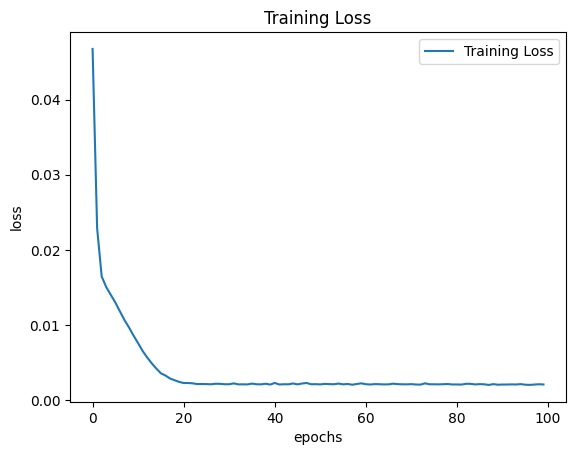

In [17]:
# ambil statistik pelatihan
loss = history.history['loss']

epochs_range = range(100)

# plot hasil loss pelatihan
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Training Loss')
plt.show()

# **7. Prediksi Data Test**

In [18]:
from tensorflow.keras.models import load_model

# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# Prediksi pada test dataset
testPredict = trained_model.predict(testX)

print(testY)
print(testPredict)

# Perhitungan RMSE (Root Mean Square Error) pada hasil prediksi
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 1s 7ms/step
[[0.6138996 ]
 [0.6969112 ]
 [0.70077217]
 [0.57915056]
 [0.46911195]
 [0.38803086]
 [0.44787642]
 [0.45559844]
 [0.4131274 ]
 [0.4980695 ]
 [0.47104248]
 [0.49999997]
 [0.6389961 ]
 [0.7471043 ]
 [0.7741313 ]
 [0.57915056]
 [0.492278  ]
 [0.3976834 ]
 [0.44980696]
 [0.49420848]
 [0.45945945]
 [0.5830116 ]
 [0.5637065 ]
 [0.61003864]
 [0.71042466]
 [0.8571429 ]
 [0.8783784 ]
 [0.69305015]
 [0.5849421 ]
 [0.4980695 ]
 [0.58108103]
 [0.6042471 ]
 [0.554054  ]
 [0.60810804]
 [0.6891892 ]
 [0.71042466]
 [0.8320464 ]
 [1.        ]
 [0.96911204]
 [0.7799227 ]
 [0.6891892 ]
 [0.55212355]
 [0.6332046 ]]
[[0.4561564 ]
 [0.5798486 ]
 [0.6575052 ]
 [0.66107357]
 [0.54687786]
 [0.44125697]
 [0.36296067]
 [0.4207518 ]
 [0.42821002]
 [0.3871843 ]
 [0.4691797 ]
 [0.4431202 ]
 [0.4710389 ]
 [0.6035029 ]
 [0.7035591 ]
 [0.7280401 ]
 [0.54687786]
 [0.46360004]
 [0.37227362]
 [0.4226165 ]
 [0.46546027]
 [0.4319385 ]
 [0.55055285]
 [0.532152  ]
 [0.576197

Hasil RMSE yang diperoleh adalah 0.1. Hal ini menunjukkan perbedaan antara hasil prediksi data ke t+1 dengan data t+1 sesungguhnya berkisar antara 0.1.  Menurut Anda apakah hasil ini sudah baik atau belum?

# **8. Visualisasi Hasil Prediksi pada Data Test dan Nilai Sebenarnya**

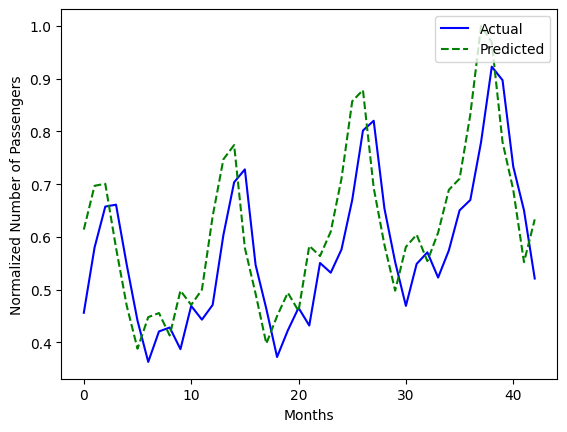

In [19]:
# plot hasil prediksi dengan garis warna biru
plt.plot(testPredict, 'b-', label='Actual') 
# plot hasil prediksi dengan garis putus-putus warna hijau
plt.plot(testY, 'g--', label='Predicted') 
plt.xlabel('Months')
plt.ylabel('Normalized Number of Passengers')
plt.legend(loc='upper right')
plt.show()

## **Windowing**

Pada bagian selanjutnya kita akan mencoba menggunakan ukuran window lebih besar dari 1.  Kita akan mencoba menggunakan window berukuran 4. Artinya kita akan memprediksi data ke-t+1 dengan menggunakan 4 data sebelumnya yaitu data ke-t, data ke t-1, data ke t-2, dan data ke t-3. Dalam hal ini kita perlu mengubah sedikit fungsi create_dataset sebagai berikut.

In [48]:
def create_dataset_window(dataset, look_back):
    dataX,dataY=[],[]
  
    for i in range(len(dataset)- look_back):
        a = []
        for j in range (0, look_back):
            a.append(dataset[i+j]) # a menyimpan data yang termasuk dalam window
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return numpy.array(dataX), numpy.array(dataY)

In [54]:
# panggil fungsi create_dataset pada data yang sudah ternormalisasi 
# dengan look_back = 4
# menghasilkan data X=t and Y=t+1
look_back = 4
trainX_window4, trainY_window4 = create_dataset_window(train, look_back)
testX_window4, testY_window4 = create_dataset_window(test, look_back)  

In [55]:
trainX_window4[:5]

array([[[0.01544401],
        [0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853]],

       [[0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984557]],

       [[0.04826255],
        [0.03281853],
        [0.05984557],
        [0.08494207]],

       [[0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207]]], dtype=float32)

In [50]:
# tampilkan data yang telah dihasilkan
print(trainX_window4)
print(len(trainX_window4))

print(trainY_window4)
print(len(trainY_window4))

[[[0.01544401]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]]

 [[0.05984557]
  [0.08494207]
  [0.08494207]]

 [[0.08494207]
  [0.08494207]
  [0.06177607]]

 [[0.08494207]
  [0.06177607]
  [0.02895753]]

 [[0.06177607]
  [0.02895753]
  [0.        ]]

 [[0.02895753]
  [0.        ]
  [0.02702703]]

 [[0.        ]
  [0.02702703]
  [0.02123553]]

 [[0.02702703]
  [0.02123553]
  [0.04247104]]

 [[0.02123553]
  [0.04247104]
  [0.07142857]]

 [[0.04247104]
  [0.07142857]
  [0.05984557]]

 [[0.07142857]
  [0.05984557]
  [0.04054055]]

 [[0.05984557]
  [0.04054055]
  [0.08687258]]

 [[0.04054055]
  [0.08687258]
  [0.12741312]]

 [[0.08687258]
  [0.12741312]
  [0.12741312]]

 [[0.12741312]
  [0.12741312]
  [0.10424709]]

 [[0.12741312]
  [0.10424709]
  [0.05598456]]

 [[0.10424709]
  [0.05598456]
  [0.01930502]]

 [[0.05598456

Perhatikan pada trainX_window4 dari data yang kita hasilkan, data pertama terdiri dari data ke 1, 2, 3, 4.  Data kedua terdiri dari data ke 2,3,4,5. Data ketiga terdiri dari data ke 3,4,5,6. Sedangkan pada trainY_window4 data pertama adalah data ke 5, data kedua adalah data ke 6, data ketiga adalah data ke 7.

In [23]:
# reshape input to be [samples, time steps, features]
trainX_window4 = numpy.reshape(trainX_window4, 
                               (trainX_window4.shape[0], 1, trainX_window4.shape[1]))
testX_window4 = numpy.reshape(testX_window4, 
                              (testX_window4.shape[0], 1, testX_window4.shape[1]))

In [24]:
# membangun model dengan LSTM 
model = Sequential()
#LSTM dengan 1 input dan 4 time-step dan LSTM memiliki 4 hidden layer
model.add(LSTM(4, input_shape=(1, 4)))
# ouput prediksi memiliki 1 nilai saja 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', 
              optimizer='adam')

# menampilkan summary dari model yang dibuat
model.summary()

# simpan model yang mendapatkan akurasi validasi tertinggi
checkpoint_filepath = os.path.join(root_path, 'lab06_lstm_model_rev.h5') 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=False, 
    monitor='loss', 
    verbose=1, 
    mode='auto', 
    save_best_only=True) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 144       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [25]:
# epoch yang digunakan 100 dan batch_size = 1
model.fit(trainX_window4, 
          trainY_window4, 
          epochs=100, 
          batch_size=1, 
          callbacks=[model_checkpoint_callback],
          verbose=1)

Epoch 1/100
88/96 [==========================>...] - ETA: 0s - loss: 0.0842
Epoch 1: loss improved from inf to 0.07937, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model_rev.h5
96/96 [==============================] - 2s 3ms/step - loss: 0.0794
Epoch 2/100
87/96 [==========================>...] - ETA: 0s - loss: 0.0307
Epoch 2: loss improved from 0.07937 to 0.03524, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model_rev.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 3/100
94/96 [============================>.] - ETA: 0s - loss: 0.0209
Epoch 3: loss improved from 0.03524 to 0.02084, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model_rev.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 4/100
84/96 [=========================>....] - ETA: 0s - loss: 0.0172
Epoch 4: loss improved from 0.02084 to 0.01

In [26]:
# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# Prediksi pada test dataset
testPredict = trained_model.predict(testX_window4)

print(testY_window4)
print(testPredict)

# Perhitungan RMSE (Root Mean Square Error) pada hasil prediksi
testScore = math.sqrt(mean_squared_error(testY_window4, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 6ms/step
[[0.57915056]
 [0.46911195]
 [0.38803086]
 [0.44787642]
 [0.45559844]
 [0.4131274 ]
 [0.4980695 ]
 [0.47104248]
 [0.49999997]
 [0.6389961 ]
 [0.7471043 ]
 [0.7741313 ]
 [0.57915056]
 [0.492278  ]
 [0.3976834 ]
 [0.44980696]
 [0.49420848]
 [0.45945945]
 [0.5830116 ]
 [0.5637065 ]
 [0.61003864]
 [0.71042466]
 [0.8571429 ]
 [0.8783784 ]
 [0.69305015]
 [0.5849421 ]
 [0.4980695 ]
 [0.58108103]
 [0.6042471 ]
 [0.554054  ]
 [0.60810804]
 [0.6891892 ]
 [0.71042466]
 [0.8320464 ]
 [1.        ]
 [0.96911204]
 [0.7799227 ]
 [0.6891892 ]
 [0.55212355]
 [0.6332046 ]]
[[0.6547171 ]
 [0.49728814]
 [0.40296653]
 [0.35387793]
 [0.4565688 ]
 [0.46388444]
 [0.42810208]
 [0.5200968 ]
 [0.47120753]
 [0.5146202 ]
 [0.64119714]
 [0.7206637 ]
 [0.71187055]
 [0.46617416]
 [0.4136859 ]
 [0.34432867]
 [0.45651087]
 [0.5013269 ]
 [0.46769533]
 [0.5998186 ]
 [0.5423814 ]
 [0.6020498 ]
 [0.67145616]
 [0.7935082 ]
 [0.7564023 ]
 [0.52575785]
 [0.4409182 ]
 [0.392467

Perhatikan hasil RMSE 0.13, dengan menggunakan window berukuran 4 ternyata hasilnya tdak lebih baik dari pada menggunakan window berukuran 1 (RMSE 0.1). Anda dapat bereksperimen dengan mengganti epoch yang lebih tinggi.

# **POST TEST**

Dengan menggunakan dataset yang sama (*airline_passangers.csv*) modifikasi lah fungsi create_dataset_window sehingga menghasilkan pola data sebagai berikut:

X : [data t-4, data t-2,  data t] 

Y : [data t+2]

Artinya untuk memprediksi data t+2 kita gunakan data t-4, data t-2, dan data t.  Lalu lakukan prediksi dengan LSTM yang memiliki jumlah hidden layer 5. Gunakan epoch 100 dan batch size 1. Hitunglah hasil RMSE nya!

# **Pembentukan (Konstruksi) Data Time-Series**

In [61]:
def create_dataset_window(dataset, look_back):
    dataX,dataY=[],[]
  
    for i in range(len(dataset)- look_back):
        a = []
        for j in range (0, look_back):
            a.append(dataset[i+j]) # a menyimpan data yang termasuk dalam window
        dataX.append(a)
        dataY.append(dataset[i + look_back - 2])

    return numpy.array(dataX), numpy.array(dataY)

In [62]:
# panggil fungsi create_dataset pada data yang sudah ternormalisasi
# menghasilkan data X= [4,2,1] and Y=t+2
look_back = 5
trainX_win, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [63]:
trainX_win[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [46]:
trainY[:5]

array([[0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [31]:
# tampilkan data pada trainX dan train Y
for i in range (len(trainX)):
    print(trainX[i], trainY[i])

print(len(trainX))
print(len(trainY))

[0.01544401] [0.05984557]
[0.02702703] [0.08494207]
[0.05405405] [0.08494207]
[0.04826255] [0.06177607]
[0.03281853] [0.02895753]
[0.05984557] [0.]
[0.08494207] [0.02702703]
[0.08494207] [0.02123553]
[0.06177607] [0.04247104]
[0.02895753] [0.07142857]
[0.] [0.05984557]
[0.02702703] [0.04054055]
[0.02123553] [0.08687258]
[0.04247104] [0.12741312]
[0.07142857] [0.12741312]
[0.05984557] [0.10424709]
[0.04054055] [0.05598456]
[0.08687258] [0.01930502]
[0.12741312] [0.06949806]
[0.12741312] [0.07915059]
[0.10424709] [0.08880308]
[0.05598456] [0.14285713]
[0.01930502] [0.11389962]
[0.06949806] [0.13127413]
[0.07915059] [0.14285713]
[0.08880308] [0.18339768]
[0.14285713] [0.18339768]
[0.11389962] [0.15444016]
[0.13127413] [0.11196911]
[0.14285713] [0.08108109]
[0.18339768] [0.1196911]
[0.18339768] [0.12934363]
[0.15444016] [0.14671814]
[0.11196911] [0.17181468]
[0.08108109] [0.14864865]
[0.1196911] [0.15250966]
[0.12934363] [0.22007722]
[0.14671814] [0.24324325]
[0.17181468] [0.26640925]
[0.1

Sampai di sini, apakah kalian paham mengapa jumlah data pada trainX dan trainY adalah 99 dan bukan 100? 

# **Training Model LSTM**

Selanjutnya, yang akan kita lakukan adalah kita membangun model dengan LSTM untuk memprediksi nilai trainY dengan menggunakan nilai trainX. Setelah model berhasil dibuat, kita akan memprediksi nilai testY dengan menggunakan testX.

LSTM menerima input data dalam struktur array yang spesifik yaitu: **[samples, time steps, features]**.

Saat ini data yang kita miliki berada dalam format **[samples, features]** dan kita berasumsi bahwa satu timestep untuk setiap sample. 

Oleh karena itu, kita perlu melakukan transformasi pada data trainX (yang akan dipakai untuk mentraining model) dan  testX(yang akan dipakai sebagai input saat testing) dengan numpy.reshape().

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Cek hasil reshape dengan print
print(trainX)

[[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]

 [[0.05984557]]

 [[0.08494207]]

 [[0.08494207]]

 [[0.06177607]]

 [[0.02895753]]

 [[0.        ]]

 [[0.02702703]]

 [[0.02123553]]

 [[0.04247104]]

 [[0.07142857]]

 [[0.05984557]]

 [[0.04054055]]

 [[0.08687258]]

 [[0.12741312]]

 [[0.12741312]]

 [[0.10424709]]

 [[0.05598456]]

 [[0.01930502]]

 [[0.06949806]]

 [[0.07915059]]

 [[0.08880308]]

 [[0.14285713]]

 [[0.11389962]]

 [[0.13127413]]

 [[0.14285713]]

 [[0.18339768]]

 [[0.18339768]]

 [[0.15444016]]

 [[0.11196911]]

 [[0.08108109]]

 [[0.1196911 ]]

 [[0.12934363]]

 [[0.14671814]]

 [[0.17181468]]

 [[0.14864865]]

 [[0.15250966]]

 [[0.22007722]]

 [[0.24324325]]

 [[0.26640925]]

 [[0.2027027 ]]

 [[0.16795367]]

 [[0.13127413]]

 [[0.17374519]]

 [[0.17760617]]

 [[0.17760617]]

 [[0.25482625]]

 [[0.25289574]]

 [[0.24131274]]

 [[0.26833975]]

 [[0.3088803 ]]

 [[0.32432434]]

 [[0.25675675]]

 [[0.20656371]]

 [[0.14671814]

In [ ]:
# Cek hasil reshape dengan print
print(testX)

[[[0.484556  ]]

 [[0.6138996 ]]

 [[0.6969112 ]]

 [[0.70077217]]

 [[0.57915056]]

 [[0.46911195]]

 [[0.38803086]]

 [[0.44787642]]

 [[0.45559844]]

 [[0.4131274 ]]

 [[0.4980695 ]]

 [[0.47104248]]

 [[0.49999997]]

 [[0.6389961 ]]

 [[0.7471043 ]]

 [[0.7741313 ]]

 [[0.57915056]]

 [[0.492278  ]]

 [[0.3976834 ]]

 [[0.44980696]]

 [[0.49420848]]

 [[0.45945945]]

 [[0.5830116 ]]

 [[0.5637065 ]]

 [[0.61003864]]

 [[0.71042466]]

 [[0.8571429 ]]

 [[0.8783784 ]]

 [[0.69305015]]

 [[0.5849421 ]]

 [[0.4980695 ]]

 [[0.58108103]]

 [[0.6042471 ]]

 [[0.554054  ]]

 [[0.60810804]]

 [[0.6891892 ]]

 [[0.71042466]]

 [[0.8320464 ]]

 [[1.        ]]

 [[0.96911204]]

 [[0.7799227 ]]

 [[0.6891892 ]]

 [[0.55212355]]]


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# membangun model dengan LSTM 
model = Sequential()
# LSTM dengan 1 input dan 1 time-step dan LSTM memiliki 5 hidden layer
model.add(LSTM(5, input_shape=(1, 1)))
# ouput prediksi memiliki 1 nilai saja 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam')

# menampilkan summary dari model yang dibuat
model.summary()

# simpan model yang mendapatkan akurasi validasi tertinggi
checkpoint_filepath = os.path.join(root_path, 'lab06_lstm_model.h5') 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=False, 
    monitor='loss', 
    verbose=1, 
    mode='auto', 
    save_best_only=True) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# epoch yang digunakan 100 dan batch_size = 1
history = model.fit(trainX, 
            trainY, 
            epochs=100, 
            batch_size=1, 
            callbacks=[model_checkpoint_callback],
            verbose=1)

Epoch 1/100
89/99 [=========================>....] - ETA: 0s - loss: 0.0471
Epoch 1: loss improved from inf to 0.04674, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 7s 3ms/step - loss: 0.0467
Epoch 2/100
87/99 [=========================>....] - ETA: 0s - loss: 0.0220
Epoch 2: loss improved from 0.04674 to 0.02290, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 3/100
88/99 [=========================>....] - ETA: 0s - loss: 0.0170
Epoch 3: loss improved from 0.02290 to 0.01649, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 6/lab06_lstm_model.h5
99/99 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 4/100
86/99 [=========================>....] - ETA: 0s - loss: 0.0151
Epoch 4: loss improved from 0.01649 to 0.01507, saving 

## Menampilkan statistik pelatihan

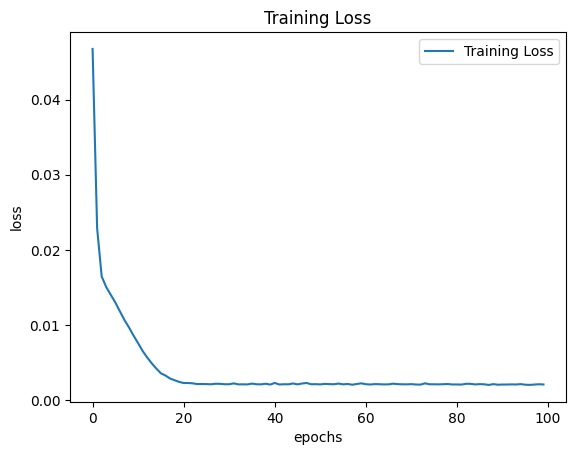

In [ ]:
# ambil statistik pelatihan
loss = history.history['loss']

epochs_range = range(100)

# plot hasil loss pelatihan
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Training Loss')
plt.show()